# Covid-19 model with "true" parameters

In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook
from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

from covid.dataset import get_contact_matrices, fetch_daily_case
from covid.utils import clean_series
from covid.models.examples.covid import COVID19
from covid.models.examples.covid_category import COVID19Category

## True data

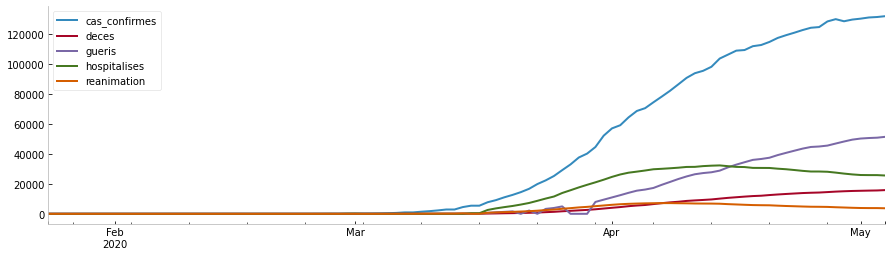

In [3]:
cases = fetch_daily_case(return_data=True)

cases_fr = (
    cases.query("granularite =='pays'")
    .query("source_nom=='Ministère des Solidarités et de la Santé'")
    [["date","cas_confirmes","deces","gueris","hospitalises","reanimation"]]
    .drop_duplicates(subset = ["date"])
    .fillna(0.0)
    .assign(date = lambda x : pd.to_datetime(x["date"]))
    .set_index("date")
)

start,end = cases_fr.index[0],cases_fr.index[-1]
date_range = pd.date_range(start,end,freq="D")
cases_fr = cases_fr.reindex(date_range).fillna(method="ffill")

cases_fr.plot(figsize = (15,4))
plt.show()

cases_fr["Is"] = clean_series(cases_fr["cas_confirmes"] - (cases_fr["deces"] + cases_fr["gueris"]))
cases_fr["D"] = clean_series(cases_fr["deces"])
cases_fr["R"] = clean_series(cases_fr["gueris"])
cases_fr["H"] = clean_series(cases_fr["hospitalises"])
cases_fr["ICU"] = clean_series(cases_fr["reanimation"])


## Gouvernement response in the contact matrix

In [18]:
contact_matrices = get_contact_matrices()["non"]

date_format = "%m/%d/%Y"
lockdown_start = datetime.strptime('3/13/2020', date_format)
lockdown_end = datetime.strptime('5/11/2020', date_format)

def contact_matrix_response(y, t):
    if t < (lockdown_start-start).days or t > (lockdown_end-start).days:
        return {"category": contact_matrices["domicile"] + contact_matrices["ecoles"] +\
                contact_matrices["centreLoisir"] + contact_matrices["chezProchesLieuxClos"] +\
                contact_matrices['autresLieuxClos(resto..)'] + contact_matrices["transport"] +\
                contact_matrices["ouvert"]}
    
    else:
        return {"category": contact_matrices["domicile"] +\
                0.2 * contact_matrices['autresLieuxClos(resto..)'] + contact_matrices["ouvert"]}

## Now for the model parameters

In [19]:
categories = ["young","adult","senior"]

N = [13.45e6, 36.05e6, 15.39e6] #source: https://www.insee.fr/fr/statistiques/3696315

# Parameters from INSERM paper
incubation_rate = 1/5.2

recovery_rate_asymptomatic = 1/2.5
recovery_rate_mild = 1/2.5

proba_symptomatic = 0.8
proba_mild = np.array([0, 0.7, 0.6])*proba_symptomatic
proba_severe = np.array([0, 0.1, 0.2])*proba_symptomatic

proba_icu = np.array([0, 0.36, 0.2])
hospitalization_rate = 1/2.5*(1-proba_icu)
hospital_exit_rate = np.array([0, 0.072, 0.022])
icu_exit_rate = np.array([0, 0.05, 0.036])
death_hospital_rate = np.array([0, 0.0042, 0.014])
death_icu_rate = np.array([0, 0.0074, 0.029])


class COVID19Model(COVID19Category):
    
    def __init__(self,params = None):
        if params is not None:
            self.reset(params)
    
    def reset(self,params):
        super().__init__(N,
                         [params["beta_young"], params["beta_adult"], params["beta_senior"]],
                         incubation_rate,
                         recovery_rate_asymptomatic,
                         recovery_rate_mild,
                         hospitalization_rate,
                         proba_mild,
                         proba_severe,
                         proba_icu,
                         death_icu_rate,
                         death_hospital_rate,
                         hospital_exit_rate,
                         icu_exit_rate,
                         categories,
                         contact=contact_matrix_response) 
        
model = COVID19Model({"beta_young": 0.3 , "beta_adult": 0.3, "beta_senior": 0.3})

## Parameters optimization

In [ ]:
space = {
    "beta_young":(0.1, 0.6),
    "beta_adult":(0.1, 0.6),
    "beta_senior":(0.1, 0.6)
}

model.fit(cases_fr[["D"]], space, 
          {"S_young":13.45e6, "S_adult": 36.05e6 - 1.0, "S_senior": 15.39e6,
          "E_young":0.0, "E_adult": 1.0, "E_old": 0.0},
          100,
          early_stopping = 50)


In [ ]:
states = model.solve({"S_young":13.45e6, "S_adult": 36.05e6 - 1.0, "S_senior": 15.39e6,
                      "E_young":0.0, "E_adult": 1.0, "E_old": 0.0}, 200)


In [ ]:
model.contact